# **IBL - Processed Mesoscope Imaging Data**

This tutorial shows how to access data from <[DANDI:00XXXX](https://dandiarchive.org/dandiset/00XXXX/draft)> for the IBL mesoscope dataset

## Study Overview

[TODO add description]

## Contents

1. [Setup and Data Access](#setup)
2. [Session and Subject Metadata](#metadata)
3. [Motion Corrected Imaging Data and Metadata](#mc)
4. [Segmentation Data and Metadata](#seg)
5. [Anatomical Localization](#loc)

---

# 1. Setup and Data Access <a id="setup"></a>

## Import Required Libraries

In [2]:
# Core data manipulation and analysis
from pathlib import Path

import h5py

# Visualization
import matplotlib.pyplot as plt
import remfile
from dandi.dandiapi import DandiAPIClient

# NWB and DANDI access
from pynwb import NWBHDF5IO

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Data Access Functions

In [3]:
def load_nwb_from_dandi(dandiset_id, subject_id, session_id):
    """
    Load NWB file from DANDI Archive via streaming.
    """
    pattern = f"sub-{subject_id}/sub-{subject_id}_ses-{session_id}*.nwb"
    
    with DandiAPIClient() as client:
        client.dandi_authenticate()
        assets = client.get_dandiset(dandiset_id, "draft").get_assets_by_glob(
            pattern=pattern, order="path"
        )
        
        s3_urls = []
        for asset in assets:
            s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)
            s3_urls.append(s3_url)
        
        if len(s3_urls) != 1:
            raise ValueError(f"Expected 1 file, found {len(s3_urls)} for pattern {pattern}")
        
        s3_url = s3_urls[0]
    
    file = remfile.File(s3_url)
    h5_file = h5py.File(file, "r")
    io = NWBHDF5IO(file=h5_file, load_namespaces=True)
    nwbfile = io.read()
    
    return nwbfile, io


def load_nwb_local(directory_path, subject_id, session_id):
    """
    Load NWB file from local directory.
    """
    directory_path = Path(directory_path)
    nwbfile_path = directory_path / f"sub-{subject_id}_ses-{session_id}.nwb"
    
    if not nwbfile_path.exists():
        raise FileNotFoundError(f"NWB file not found: {nwbfile_path}")
    
    io = NWBHDF5IO(path=nwbfile_path, load_namespaces=True)
    nwbfile = io.read()
    
    return nwbfile, io

---

# 2. Session and Subject Metadata <a id="metadata"></a>

In [4]:
# Load session data
dandiset_id = "00XXXX" #TODO Replace with actual DANDI dandiset ID
subject_id = "SP061"  # Example subject
# session_id = "5ce2e17e-8471-42d4-8a16-21949710b328"  # EID for the session
session_id = "42d7e11e-3185-4a79-a6ad-bbaf47366db2"  # EID for the session


# Choose data source (DANDI streaming or local)
USE_DANDI = False  # Set to False to use local files

if USE_DANDI:
    nwbfile, io = load_nwb_from_dandi(dandiset_id, subject_id, session_id)
else:
    # Specify your local directory path
    local_directory = "E:/ibl_mesoscope_conversion_nwb/processed/nwb_stub"  # Replace with actual path
    nwbfile, io = load_nwb_local(local_directory, subject_id, session_id)

print("=== SESSION INFORMATION ===")
print(f"Experiment description:\n {nwbfile.experiment_description}")
print(f"Session description:\n {nwbfile.session_description}")
print(f"Session start time:\n {nwbfile.session_start_time}")

=== SESSION INFORMATION ===
Experiment description:
 None
Session description:
 A rich text description of the experiment. Can also just be the abstract of the publication.
Session start time:
 2020-01-01 00:00:00-05:00


In [5]:
print("=== SUBJECT INFORMATION ===")
print(f"ID: {nwbfile.subject.subject_id}")
print(f"Age: {nwbfile.subject.age}")
print(f"Strain: {nwbfile.subject.species}")
print(f"Genotype: {nwbfile.subject.genotype}")
print(f"Sex: {nwbfile.subject.sex}")

=== SUBJECT INFORMATION ===
ID: SP061
Age: TBD
Strain: Mus musculus
Genotype: None
Sex: U


---

# 3. Motion Corrected Imaging Data and Metadata <a id="mc"></a>

## Imaging Metadata

In [6]:
print("=== IMAGING METADATA ===")
print("All imaging metadata are stored in the imaging module in imaging_planes:")
print("-" * 100)
for plane_name in nwbfile.imaging_planes:
    plane = nwbfile.imaging_planes[plane_name]
    print(f"Imaging Plane: {plane_name}")
    print("-" * 100)
    print(f"  Description: {plane.description}")
    print(f"  Imaging Rate: {plane.imaging_rate} Hz")
    print(f"  Optical Channel: {plane.optical_channel[0].name}, {plane.optical_channel[0].description}")
    print(f"  Indicator: {plane.indicator}")
    print(f"  Excitation Wavelength: {plane.excitation_lambda} nm")
    print(f"  Emission Wavelength: {plane.optical_channel[0].emission_lambda} nm")
    print(f"  Location: {plane.location}")
    print(
        f"  Origin Coordinates (top left of the FOV):\n\tX \t{plane.origin_coords[0]*1e6} um\n\tY \t{plane.origin_coords[1]*1e6} um\n\tZ \t{plane.origin_coords[2]*1e6} um"
    )
    print(f"  Grid Spacing:\n\tX \t{plane.grid_spacing[0]*1e6} um\n\tY \t{plane.grid_spacing[1]*1e6} um")
    print("-"*100)

=== IMAGING METADATA ===
All imaging metadata are stored in the imaging module in imaging_planes:
----------------------------------------------------------------------------------------------------
Imaging Plane: imaging_plane_FOV_00
----------------------------------------------------------------------------------------------------
  Description: Field of view 0 (UUID: 9382753E17533643). Center location: ML=2603.2um, AP=-430.8um, DV=-591.2um. Image dimensions: 512x512 pixels.
  Imaging Rate: 5.07538 Hz
  Optical Channel: green_channel, Optical channel recording GCaMP6f Ca2+ bound emission.
  Indicator: GCaMP6f
  Excitation Wavelength: 920.0 nm
  Emission Wavelength: 510.0 nm
  Location: FOV center location: Brain region ID 450 (Allen CCF 2017)
  Origin Coordinates (top left of the FOV):
	X 	2888.4227269344624 um
	Y 	-100.53771011565694 um
	Z 	-847.470893404837 um
  Grid Spacing:
	X 	1.4023995144523218 um
	Y 	1.3683937210010826 um
------------------------------------------------------

In [ ]:
print("=== MESOSCOPE SETUP INFORMATION ===")
nwbfile.devices["TwoPhotonMesoscope"]

=== MESOSCOPE SETUP INFORMATION ===


two_photon_mesoscope pynwb.device.Device at 0x2136943124432
Fields:
  description: The two photon mesoscope used to acquire green fluorescence on several FOVs.

## Two Photon Series - Motion Corrected Imaging Data

In [ ]:
print("=== OPHYS PROCESSING MODULE ===\n")
mc_two_photon_series_names = []
for name, proc in nwbfile.processing["ophys"].items():
    if "MotionCorrected" not in name:
        continue
    print(f"{name} - {proc.description}")
    mc_two_photon_series_names.append(name)

=== OPHYS PROCESSING MODULE ===

motion_corrected_two_photon_series_FOV_00 - The motion corrected two-photon imaging data acquired using the mesoscope on FOV_00 (UUID: 9382753E17533643).
motion_corrected_two_photon_series_FOV_01 - The motion corrected two-photon imaging data acquired using the mesoscope on FOV_01 (UUID: A979760659A7E342).


In [9]:
# Access data of one example FOV 
mc_two_photon_series = nwbfile.processing["ophys"][mc_two_photon_series_names[0]]

print("=== MOTION CORRECTED TWO-PHOTON SERIES ===")
print(f"Name: {mc_two_photon_series.name}")
print(f"Description: {mc_two_photon_series.description}")
print(f"Data shape: {mc_two_photon_series.data.shape}")
print(f"Duration: {mc_two_photon_series.timestamps[-1] - mc_two_photon_series.timestamps[0]:.2f} seconds")

=== MOTION CORRECTED TWO-PHOTON SERIES ===
Name: motion_corrected_two_photon_series_FOV_00
Description: The motion corrected two-photon imaging data acquired using the mesoscope on FOV_00 (UUID: 9382753E17533643).
Data shape: (18971, 512, 512)
Duration: 3756.19 seconds


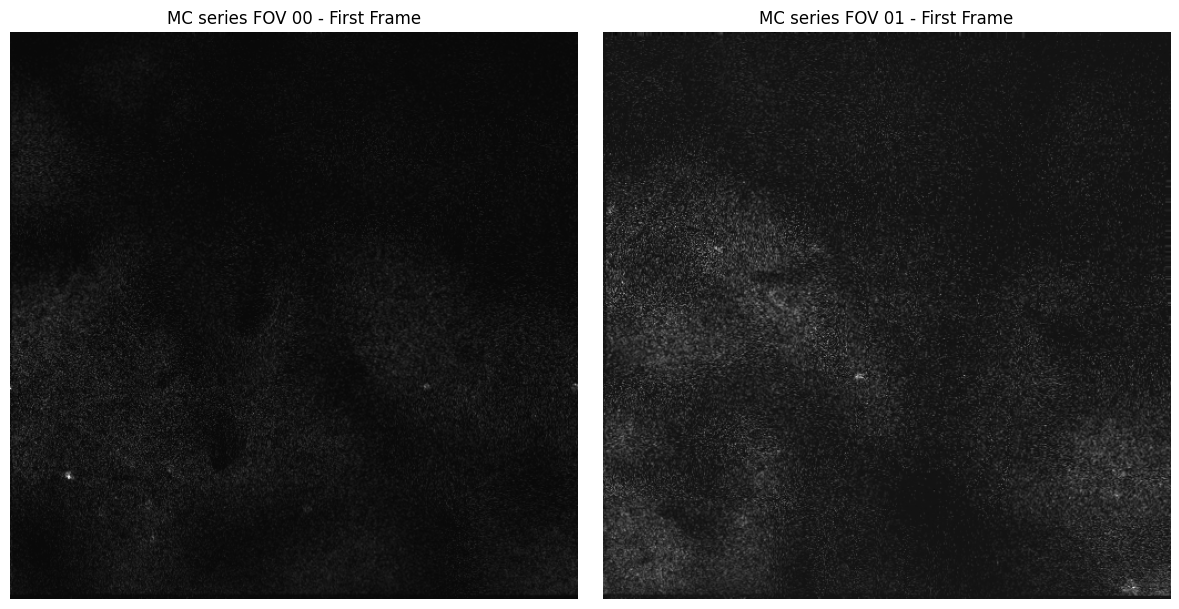

In [10]:
fig, axes = plt.subplots(1, len(mc_two_photon_series_names), sharex=True, sharey=True, dpi=100)
for i, name in enumerate(mc_two_photon_series_names):
    mc_two_photon_series = nwbfile.processing["ophys"][name]
    axes[i].imshow(mc_two_photon_series.data[0, ...], cmap="gray")
    axes[i].set_title(f"MC series FOV 0{i} - First Frame")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

TODO:
1. PLAY SHORT VIDEO TO DEMO ONE 2P SERIES
2. ADD SCHEMA OF DATA-METADATA RELATION

---

# 4. Segmentation Data and Metadata <a id="seg"></a>

In [ ]:
print("=== OPHYS PROCESSING MODULE ===\n")
for name, proc in nwbfile.processing["ophys"].items():
    if "MotionCorrected" in name:
        continue
    print(f"{name}")

=== OPHYS PROCESSING MODULE ===

Fluorescence
ImageSegmentation
SegmentationImages


## Fluorescence - Temporal Components

In [12]:
import pynwb
print(f"=== FLUORESCENCE TRACES: ===")
print("-" * 100)
for name, proc in nwbfile.processing["ophys"].data_interfaces.items():
    if isinstance(proc, pynwb.ophys.Fluorescence):
        fluorescence_module = nwbfile.processing["ophys"][name]
        for _, roi_response in fluorescence_module.roi_response_series.items():
            print(f"Trace: {roi_response.name}")
            print("-" * 100)
            print(f"   Description: {roi_response.description}")
            print(f"   Number of ROIs: {roi_response.data.shape[1]}")
            print(f"   Duration: {roi_response.timestamps[-1] - roi_response.timestamps[0]:.2f} seconds")
            print("-" * 100)

=== FLUORESCENCE TRACES: ===
----------------------------------------------------------------------------------------------------
Trace: deconvolved_response_series_FOV_00
----------------------------------------------------------------------------------------------------
   Description: The deconvolved activity traces (temporal components) of segmented ROIs for FOV_00 (UUID: 9382753E17533643).
   Number of ROIs: 1885
   Duration: 3756.19 seconds
----------------------------------------------------------------------------------------------------
Trace: deconvolved_response_series_FOV_01
----------------------------------------------------------------------------------------------------
   Description: The deconvolved activity traces (temporal components) of segmented ROIs for FOV_01 (UUID: A979760659A7E342).
   Number of ROIs: 898
   Duration: 3756.19 seconds
----------------------------------------------------------------------------------------------------
Trace: raw_response_series_

TODO PLOT:
1. plot traces for 10 random ROIs 
2. raw and deconvolved superimposed
3. n subplot (1 row n columns) n=num of FOVs
4. same time window

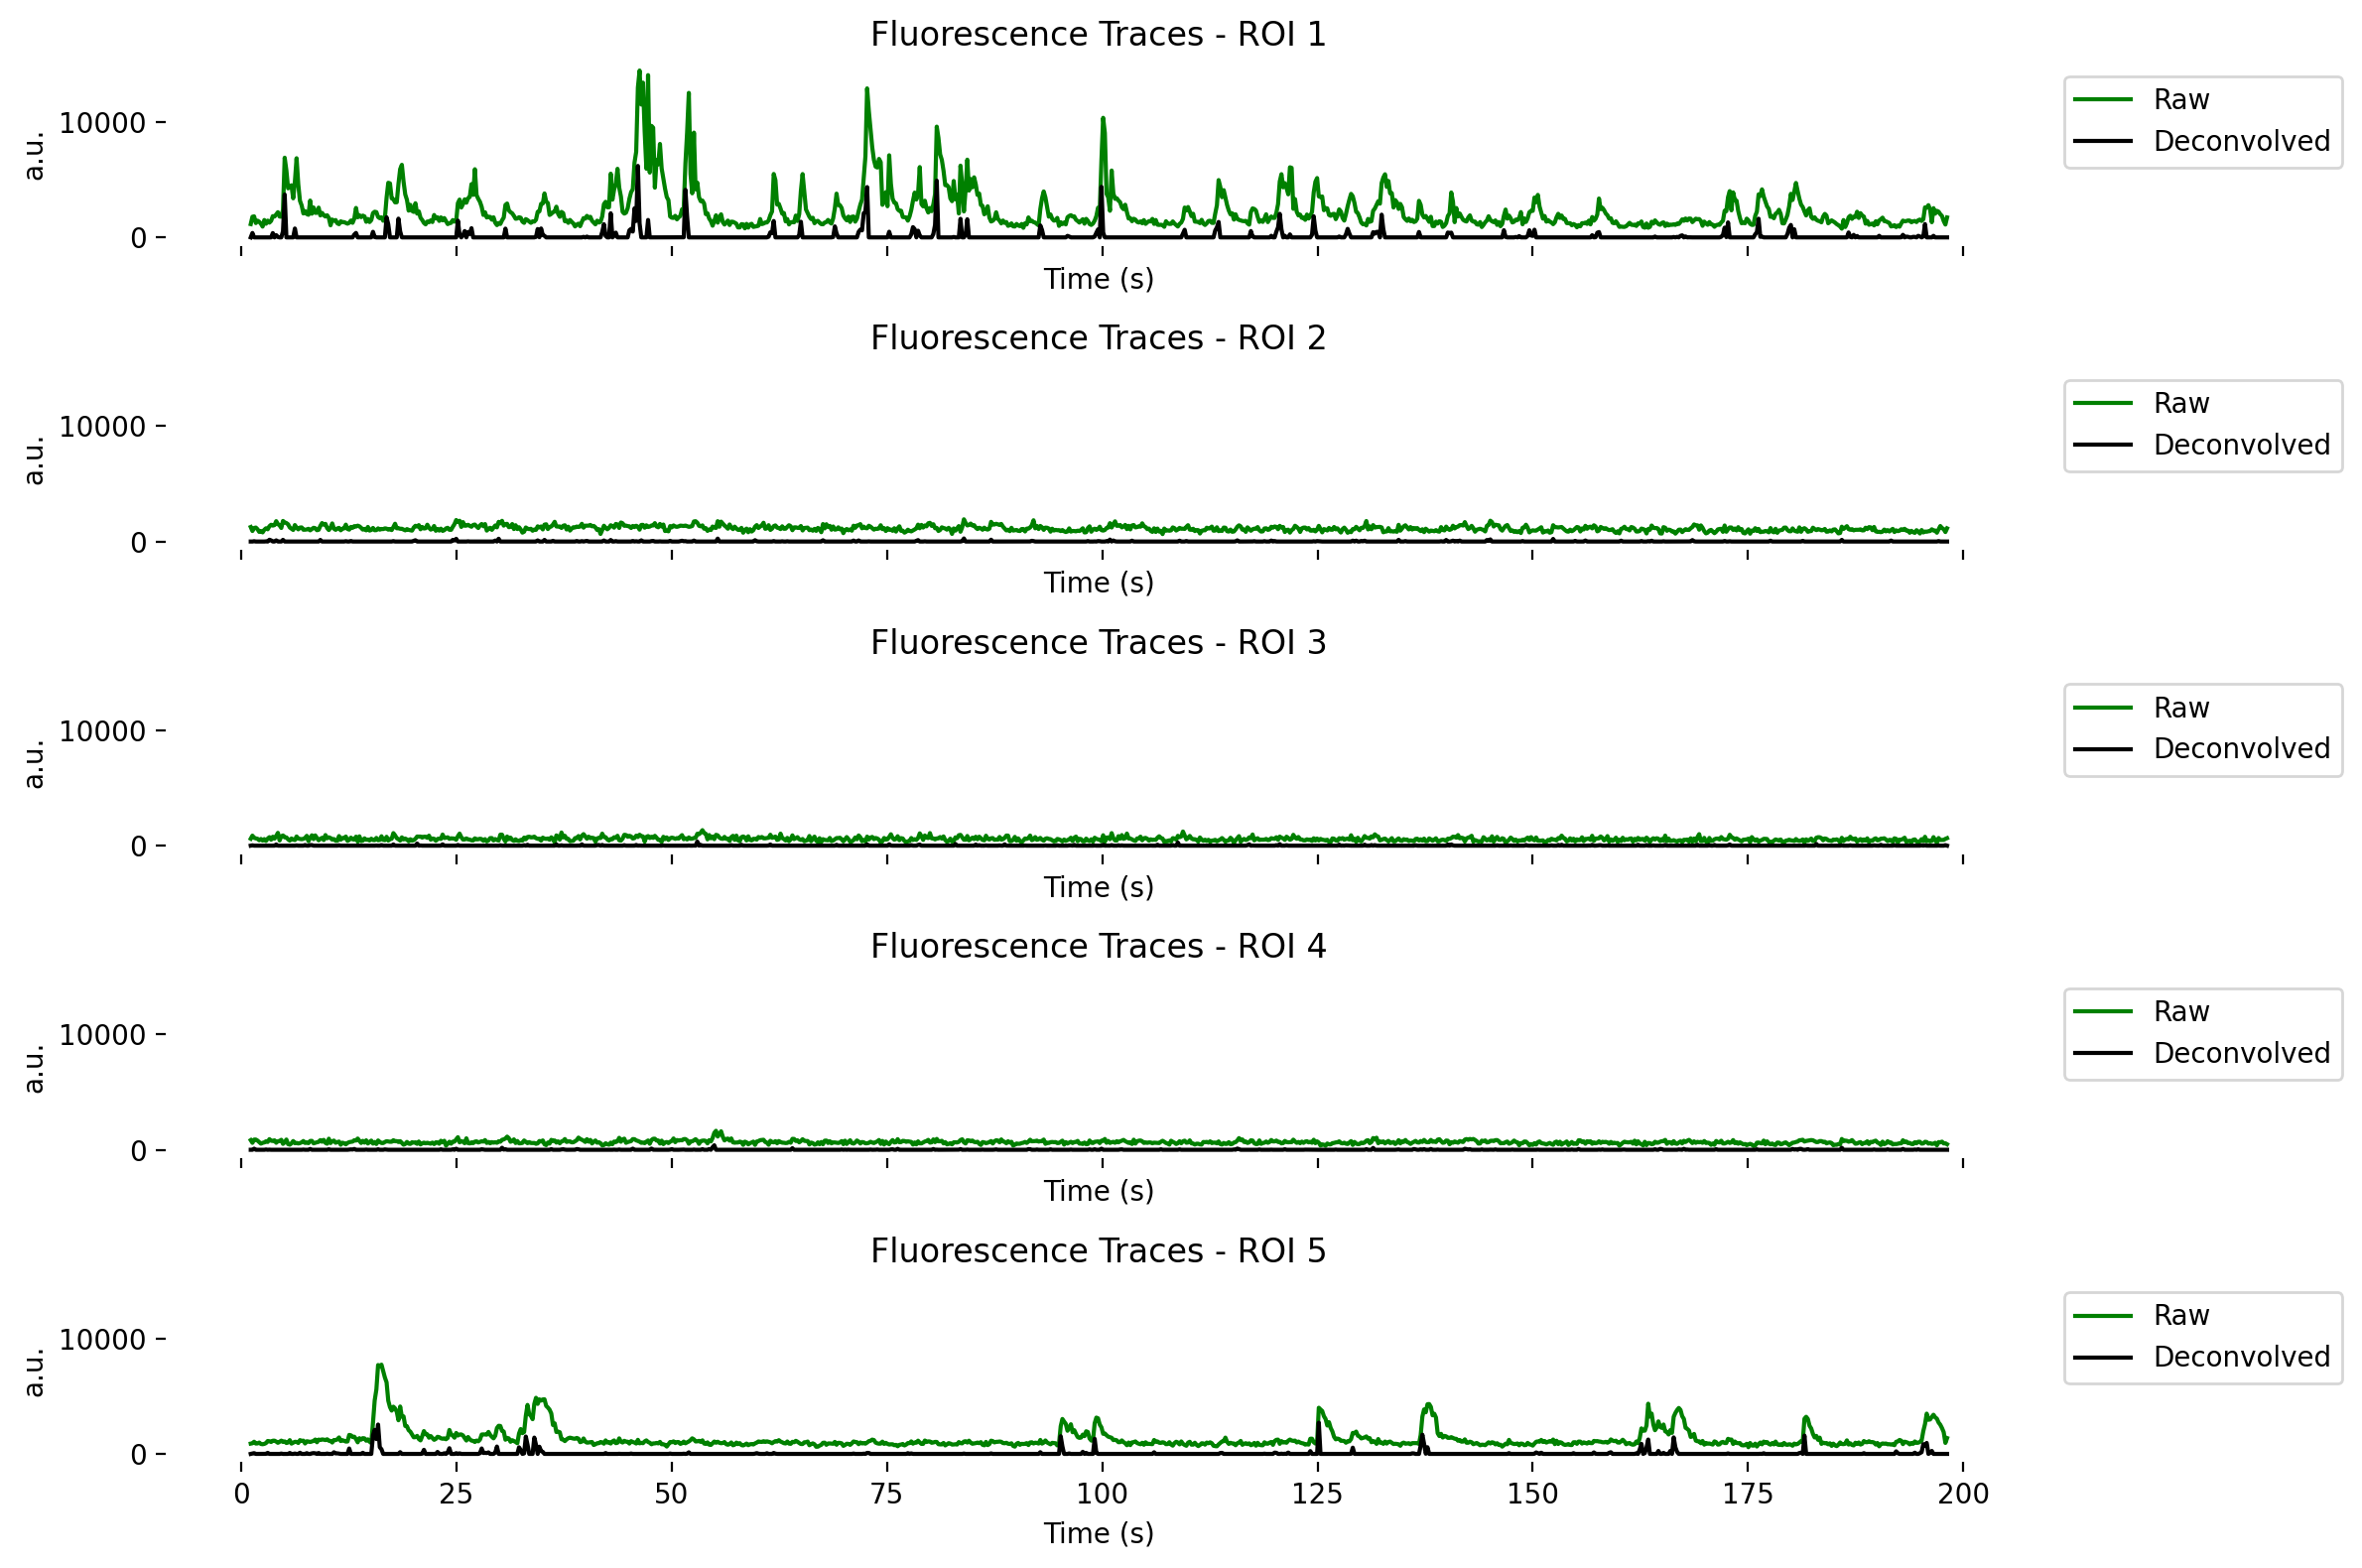

In [ ]:
num_rois = 5
fig, ax = plt.subplots(num_rois, 1, figsize=(12, 8), dpi=200, sharex=True, sharey=True)

roi_response_raw = fluorescence_module.roi_response_series["RawROIResponseSeries_FOV_00"]
roi_response_deconvolved = fluorescence_module.roi_response_series["DeconvolvedROIResponseSeries_FOV_00"]
time = roi_response_raw.timestamps[:1000]  # First 1000 time points
for roi_idx in range(num_rois):  # Plot first 5 ROIs
    ax[roi_idx].plot(time, roi_response_raw.data[:1000, roi_idx], label=f"Raw", color="green")
    ax[roi_idx].plot(time, roi_response_deconvolved.data[:1000, roi_idx], label=f"Deconvolved", color="black")
    ax[roi_idx].legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    ax[roi_idx].set_frame_on(False)
    ax[roi_idx].set_title("Fluorescence Traces - ROI {}".format(roi_idx + 1))
    ax[roi_idx].set_xlabel("Time (s)")
    ax[roi_idx].set_ylabel("a.u.")
plt.tight_layout()

## ImageSegmentation - Spatial Components

In [14]:
import pynwb
print(f"=== SEGMENTED ROIS: ===")
print("-" * 100)
for name, proc in nwbfile.processing["ophys"].data_interfaces.items():
    if isinstance(proc, pynwb.ophys.ImageSegmentation):
        segmentation_module = nwbfile.processing["ophys"][name]        
        for _, plane_segmentation in segmentation_module.plane_segmentations.items():
            print(f"Plane Segmentation: {plane_segmentation.name}")
            print("-" * 100)
            print(f"   Description: {plane_segmentation.description}")
            print(f"   Linked Imaging Plane: {plane_segmentation.imaging_plane.name}")
            display(plane_segmentation.to_dataframe().head(5))  # Print first 5 rows as example
            print("-" * 100)

=== SEGMENTED ROIS: ===
----------------------------------------------------------------------------------------------------
Plane Segmentation: plane_segmentation_FOV_00
----------------------------------------------------------------------------------------------------
   Description: Spatial components of segmented ROIs for FOV_00 (UUID: 9382753E17533643).
   Linked Imaging Plane: imaging_plane_FOV_00


,roi_name,pixel_mask,ROICentroids,Accepted,Rejected,Classifier,UUID
id,,,,,,,
0,0,"[[31, 353, 13.721694], [32, 352, 19.888052], [...","[353, 38]",1,0,0.742465,37ac1d51-eecf-4b4a-913b-c0c41c550d98
1,1,"[[5, 379, 15.522959], [5, 380, 20.040041], [5,...","[385, 8]",1,0,0.995537,b13daec5-cca5-402c-805b-fd1106ffb5a5
2,2,"[[357, 220, 9.284441], [357, 221, 25.349699], ...","[221, 360]",1,0,0.966029,6b92c347-693e-4398-a3fc-b27fa3a34a3d
3,3,"[[127, 273, 9.1335335], [128, 272, 19.572277],...","[273, 132]",1,0,0.974102,a45eada7-5e5c-4bdf-906a-3426a2a1aa0e
4,4,"[[111, 490, 8.058457], [112, 489, 15.943853], ...","[489, 116]",1,0,0.967611,8c0f473f-aef8-45b1-9212-497f977f7366


----------------------------------------------------------------------------------------------------
Plane Segmentation: plane_segmentation_FOV_01
----------------------------------------------------------------------------------------------------
   Description: Spatial components of segmented ROIs for FOV_01 (UUID: A979760659A7E342).
   Linked Imaging Plane: imaging_plane_FOV_01


,roi_name,pixel_mask,ROICentroids,Accepted,Rejected,Classifier,UUID
id,,,,,,,
0,0,"[[457, 390, 10.813429], [457, 391, 15.976293],...","[393, 461]",1,0,0.997749,08825c22-69c9-4e8c-af1f-a7aebcb59b53
1,1,"[[168, 298, 9.586297], [169, 295, 19.577726], ...","[297, 173]",1,0,0.904486,f43a0c4e-6914-472a-ba2b-7bcb849cd235
2,2,"[[501, 490, 9.60255], [501, 491, 26.804962], [...","[493, 503]",1,0,0.877164,5e9c4ae1-8bb6-4396-82db-36fc5452877b
3,3,"[[21, 177, 6.5897484], [21, 178, 10.333673], [...","[179, 25]",1,0,0.916590,3d66c4d5-4faa-4b13-8384-6921876e5346
4,4,"[[29, 388, 11.811475], [29, 389, 12.070506], [...","[389, 33]",1,0,0.964507,0dfedbd8-1c19-4dec-929e-a4348fd9577b


----------------------------------------------------------------------------------------------------


TODO PLOT:
1. plot traces and respective mask (few example)
2. plot rois masks for each FOV one next to the other all coloured

## SegmentationImages - Summary Images

In [15]:
import pynwb

print(f"=== SUMMARY IMAGES: ===")
print("-" * 100)
for name, proc in nwbfile.processing["ophys"].data_interfaces.items():
    if name == "SegmentationImages":
        summary_images_module = nwbfile.processing["ophys"][name]
        for _, summary_image in summary_images_module.images.items():
            print(f"Plane Segmentation: {summary_image.name}")
            print("-" * 100)
            print(f"   Description: {summary_image.description}")
            print(f"   Dimensions: {summary_image.data.shape}")
            print("-" * 100)

=== SUMMARY IMAGES: ===
----------------------------------------------------------------------------------------------------
Plane Segmentation: mean_image_FOV_00
----------------------------------------------------------------------------------------------------
   Description: The mean image for FOV_00 (UUID: 9382753E17533643).
   Dimensions: (512, 512)
----------------------------------------------------------------------------------------------------
Plane Segmentation: mean_image_FOV_01
----------------------------------------------------------------------------------------------------
   Description: The mean image for FOV_01 (UUID: A979760659A7E342).
   Dimensions: (512, 512)
----------------------------------------------------------------------------------------------------


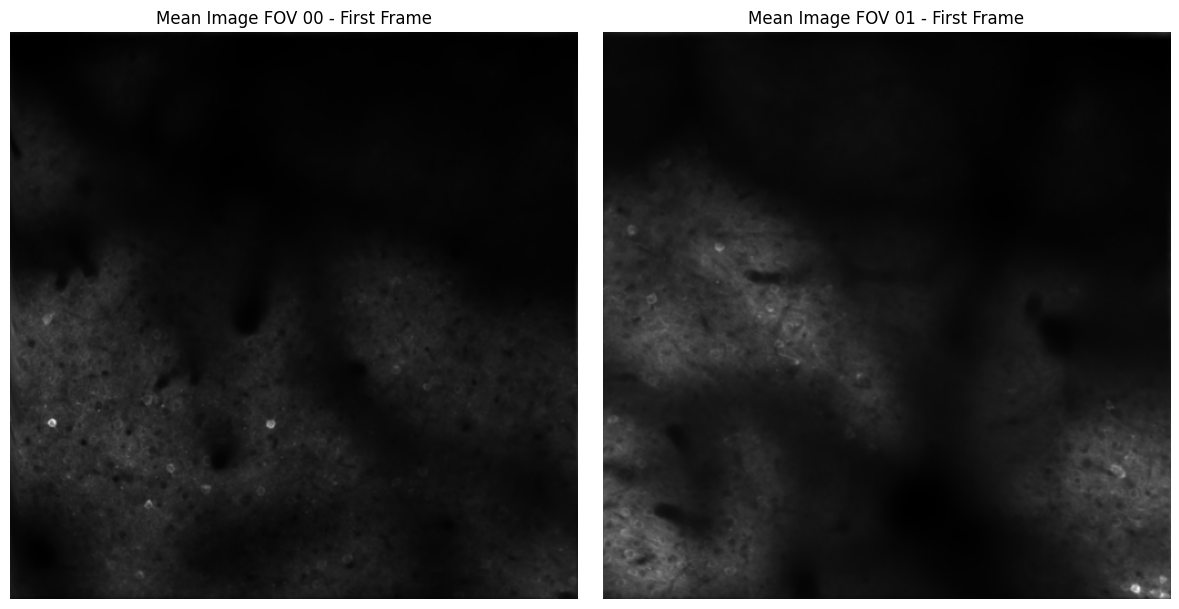

In [16]:
fig, axes = plt.subplots(1, len(mc_two_photon_series_names), sharex=True, sharey=True, dpi=100)
for i, (_, summary_image) in enumerate(summary_images_module.images.items()):
    axes[i].imshow(summary_image.data, cmap="gray")
    axes[i].set_title(f"Mean Image FOV 0{i} - First Frame")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

---

# 5. Anatomical Localization <a id="loc"></a>

TODO:
Final plot --> would be nice to have a function that plot 2p_series w roi mask marked on top next to traces of the same ROI. Input of the function would only be the FOV name and ROI id  --> it will also report CCFv3 coordinates and Brain ID and metadata from linked imaging plane

=== ANATOMICAL LOCALIZATION OF ROIS ===
----------------------------------------------------------------------------------------------------
Anatomical Coordinates Table: CCFv3_anatomical_coordinates_FOV_00_rois
   Description: ROI centroid estimated coordinates in the CCF coordinate system for FOV 00.


,x,y,z,localized_entity,brain_region_id,brain_region
id,,,,,,
0,2883.637261,-572.380826,-679.346408,roi_name ...,182305693,TODO
1,2921.910665,-617.250667,-690.836383,roi_name ...,182305693,TODO
2,2465.553695,-381.017500,-551.941045,roi_name ...,450,TODO
3,2760.072747,-460.193465,-650.458789,roi_name ...,450,TODO
4,2798.691137,-752.150251,-588.854464,roi_name ...,182305693,TODO


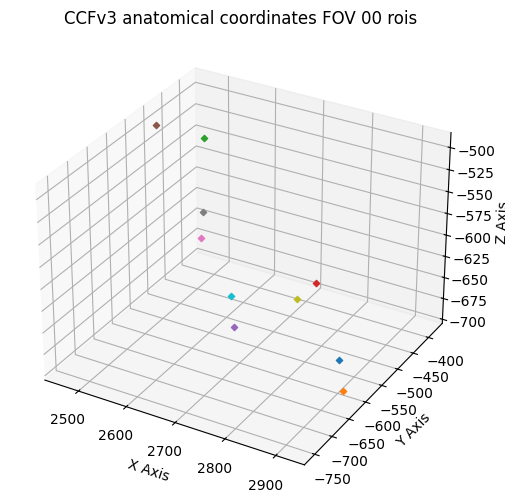

----------------------------------------------------------------------------------------------------
Anatomical Coordinates Table: CCFv3_anatomical_coordinates_FOV_01_rois
   Description: ROI centroid estimated coordinates in the CCF coordinate system for FOV 01.


,x,y,z,localized_entity,brain_region_id,brain_region
id,,,,,,
0,1699.340979,-759.300754,-178.716019,roi_name ...,1030,TODO
1,2074.048021,-637.976674,-313.635483,roi_name ...,1030,TODO
2,1645.758213,-894.224787,-147.120893,roi_name ...,1006,TODO
3,2251.939936,-484.790162,-427.721779,roi_name ...,1030,TODO
4,2263.580784,-766.888995,-345.541155,roi_name ...,1030,TODO


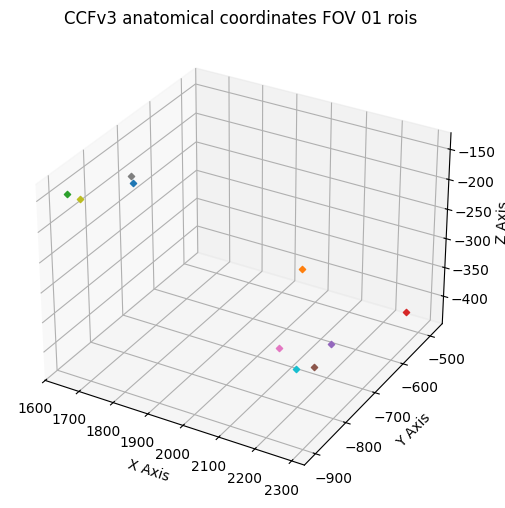

----------------------------------------------------------------------------------------------------


In [32]:
print("=== ANATOMICAL LOCALIZATION OF ROIS ===")
print("-" * 100)
for table_name in nwbfile.lab_meta_data["localization"].anatomical_coordinates_tables:
    table = nwbfile.lab_meta_data["localization"].anatomical_coordinates_tables[table_name]
    print(f"Anatomical Coordinates Table: {table_name}")
    print(f"   Description: {table.description}")
    display(table.to_dataframe().head(5))  # Print first 5 rows as example
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    for i in range(10):
        ax.scatter3D(table.x[i], table.y[i], table.z[i], marker="D", s=10)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title(f"{table_name.replace('_', ' ')}")
    plt.show()
    print("-" * 100)

=== ANATOMICAL LOCALIZATION OF MEAN IMAGES ===
----------------------------------------------------------------------------------------------------
Anatomical Coordinates Image: CCFv3_anatomical_coordinates_FOV_00_mean_image
   Description: Mean image estimated coordinates in the CCF coordinate system for FOV 00.


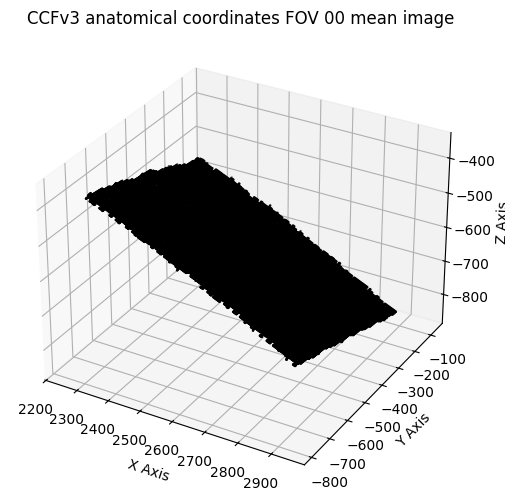

----------------------------------------------------------------------------------------------------
Anatomical Coordinates Image: CCFv3_anatomical_coordinates_FOV_01_mean_image
   Description: Mean image estimated coordinates in the CCF coordinate system for FOV 01.


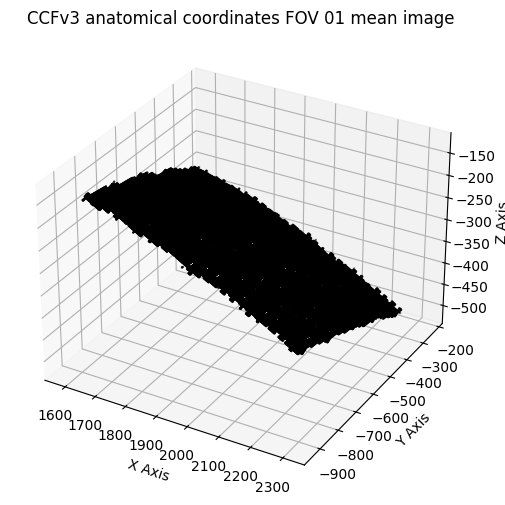

----------------------------------------------------------------------------------------------------


In [33]:
print("=== ANATOMICAL LOCALIZATION OF MEAN IMAGES ===")
print("-" * 100)

for image_name in nwbfile.lab_meta_data["localization"].anatomical_coordinates_images:
    image = nwbfile.lab_meta_data["localization"].anatomical_coordinates_images[image_name]
    print(f"Anatomical Coordinates Image: {image_name}")
    print(f"   Description: {image.description}")
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter3D(image.x, image.y, image.z, marker=".", c="black",s=1)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title(f"{image_name.replace('_', ' ')}")
    plt.show()
    print("-" * 100)